# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [55]:
print(t.)

<module 'project_tests' from '/home/workspace/project_tests.py'>

In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# 每个用户和多少篇文章互动过(从大到小排序)
articles_by_user = df.groupby(['email'])['article_id'].count().sort_values(ascending=False)
articles_by_user.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

In [8]:
int(articles_by_user.median())

3

In [7]:
articles_by_user[int(articles_by_user.shape[0]/2)] 

3

In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = int(articles_by_user.median())
print("50% of individuals interact with {} number of articles or fewer.".format(median_val))

max_views_by_user = articles_by_user[0] 
print("The maximum number of user-article interactions by any 1 user is {}".format(max_views_by_user))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles
df_content[df_content.duplicated('article_id') == True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [13]:
# Remove any rows that have the same article_id - only keep the first
df_content_u = df_content.drop_duplicates('article_id')
df_content.shape, df_content_u.shape

((1056, 5), (1051, 5))

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
unique_articles = len(np.unique(df['article_id'])) # The number of unique articles that have at least one interaction
print("The number of unique articles that have at least one interaction is {}".format(unique_articles))

total_articles = len(np.unique(df_content_u['article_id'])) # The number of unique articles on the IBM platform
print("The number of unique articles on the IBM platform is {}".format(total_articles))

unique_users = articles_by_user.shape[0] # The number of unique users
print("The number of unique users is {}".format(unique_users))

user_article_interactions = df.shape[0] # The number of user-article interactions
print("The number of user-article interactions is {}".format(user_article_interactions))

The number of unique articles that have at least one interaction is 714
The number of unique articles on the IBM platform is 1051
The number of unique users is 5148
The number of user-article interactions is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [3]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
# 每篇文章被多少人看过(从大到小排序)
views_by_article = df.groupby(['article_id'])['user_id'].count().sort_values(ascending=False)
views_by_article.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: user_id, dtype: int64

In [17]:
views_by_article.index[0]

1429.0

In [18]:
views_by_article[1429.0]

937

In [19]:
most_viewed_article_id = str(views_by_article.index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = views_by_article[1429.0] # The most viewed article in the dataset was viewed how many times?


In [20]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [21]:
##### 输入需要返回的文章个数n，输出top n 的文章title(Return the top article titles from df (not df_content)）
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # 按照每篇文章被浏览的次数给文章排序
    views_by_article = df.groupby(['article_id'])['user_id'].count().sort_values(ascending=False)
    
    # 从df里生成article_id和title的键值对（方便后续查找title）
    df_art_tit = df[['article_id','title']].drop_duplicates()
    
    top_articles = []
    
    # 按照前n个文章的id，找出对应的title，放入top_articles里
    for art_id in views_by_article.index[0:n]:
        tit_name = list(df_art_tit[df_art_tit['article_id'] == art_id]['title'])[0]
        top_articles.append(tit_name)

    return top_articles # Return the top article titles from df (not df_content)

##### 输入需要返回的文章个数n，输出top n 的文章ID
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids（此处是返回id，不是title）
    
    '''
    # Your code here
    # 按照每篇文章被浏览的次数给文章排序
    views_by_article = df.groupby(['article_id'])['user_id'].count().sort_values(ascending=False)
    
    top_articles = views_by_article.index[0:n]
 
    return top_articles # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
Float64Index([1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0,
              1162.0, 1304.0],
             dtype='float64', name='article_id')


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [5]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # df去重 （无论用户与文章互动了多少次，只留一次）
    df_u = df.drop_duplicates()
    
    # 只留下'article_id','user_id'，添加一列view，全都赋值为1（为了后续的pivot计算）
    df_new = df_u[['article_id','user_id']]
    df_new['view'] = 1
    
    # 用pivot_table把user-item展开（注意没有配对的地方都是NaN）有互动的地方，生成的是1.0
    user_item_mtx = pd.pivot_table(df_new, values='view', index=['user_id'], columns=['article_id'], aggfunc=np.max)
    
    # 用0填充所有NaN （如果用户与文章没有互动，则在该文章所在的列与用户行形成的单元格中填充 0）
    user_item_mtx = user_item_mtx.fillna(0)
    
    # 把float型转换成int型，得到1和0的矩阵
    user_item = user_item_mtx.astype("int")
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
####### 为输入用户提供最相似用户（不包括本身）
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # 找到userid对应的user_item的行
    user_idx = np.where(user_item.index == user_id)[0][0]
    # 取出该用户所在的行（该用户和所有文章的交互）
    user1_items_view = user_item.iloc[user_idx,:]
    # 用该用户所在的行（1*714） 点积 所有用户和文章的交互矩阵的转置矩阵（714*5149），得到该用户与所有用户的相似度（1*5149）
    dot_prod_user1 = user1_items_view.dot(np.transpose(user_item))

    # sort by similarity
    dot_prod_user1_sort = dot_prod_user1.sort_values(ascending = False)

    # create list of just the ids
    dot_prod_user1_list = list(dot_prod_user1_sort.index)
   
    # remove the own user's id
    most_similar_users = np.setdiff1d(dot_prod_user1_list, [user_id], assume_unique=True)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933   23 3782  203 4459  131 3870   46 4201 5041]
The 5 most similar users to user 3933 are: [   1   23 3782 4459  203]
The 3 most similar users to user 46 are: [4201   23 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
##### 根据article_ids list，返回相应的title（从df里提取的title）
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids （float或者str类型都可以，方法里会转换成float的）
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
                    ***为什么要从df里查找title，而不是用df_content_u呢？？？
    '''
    # Your code here
    
    # 从df里生成article_id和title的键值对（方便后续查找title） ***这个可以提取到函数外面生成，因为多个地方都用到了。
    df_art_tit = df[['article_id','title']].drop_duplicates()
    
    # 在df_art_tit里查找article_ids list里的id对应的title
    # 如果直接查找，顺序可能会乱掉
    # article_names = list(df_art_tit[df_art_tit['article_id'].isin(article_ids)]['title'])
    
    # 用循环来一个一个找，保证article_ids的id和article_names的title是一一对应的
    article_names = []
    for art_id in article_ids:
        art_title = list(df_art_tit[df_art_tit['article_id'] == float(art_id)]['title'])[0]
        article_names.append(art_title)
    
    return article_names # Return the article names associated with list of article ids


##### 输入用户id，返回该用户看过的文章id以及文章title（从df提取的文章title）
def get_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
                    ***这里为什么又是从df_content_u获取文章title的呢？？？
                    ***实际上df_content_u不包含所有df里的文章，所以df_content_u不是文章的全集。。。（前面的答案是否有问题呢。。。）
                    ***这里我最终还是用的df里的title来返回（不然的话不是所有文章都能找到title）
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    # 从df里生成article_id和title的键值对（方便后续查找title） ***这个可以提取到函数外面生成，因为多个地方都用到了。
    df_art_tit = df[['article_id','title']].drop_duplicates()
    
    # 找到userid对应的user_item的行
    user_idx = np.where(user_item.index == user_id)[0][0]
    
    # 取出该用户所在的行（该用户和所有文章的交互）
    user1_items_view = user_item.iloc[user_idx,:]
    
    # 取出看过的文章id
    article_ids = user1_items_view[user1_items_view == 1].index
    
    # 如果直接查找，顺序可能会乱掉
    # list(df_art_tit[df_art_tit['article_id'].isin(article_ids)]['article_id'])
    
    # 用循环来一个一个找，保证article_ids的id和article_names的title是一一对应的
    article_names = []
    for art_id in article_ids:
        art_title = list(df_art_tit[df_art_tit['article_id'] == art_id]['title'])[0]
        article_names.append(art_title)
    
    # 这时候的article_ids还是float型，需要转化成string类型（后面的测试用的是str类型）***不明白为什么一定要str。。。
    article_ids = article_ids.astype('str')
    
    return article_ids, article_names # return the ids and names


##### 输入user_id, 要推荐的文章数m，返回推荐的article_id list,如：['1024.0', '1176.0', '1305.0']
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user 返回的是推荐的article_id
    ****这里也可以同时返回文章title，但是下面的测试会有问题，所以还是只返回article_id
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    # 该用户看过的文章id
    user_viewed_ids = list(get_user_articles(user_id)[0])
    
    # 与该用户相似的其他用户（按照相似度从大到小排序）
    similar_users = find_similar_users(user_id)
    
    recs = np.array([])
    
    for ngbr_id in similar_users:
        # 相邻的用户看了什么文章
        neighbor_viewed_ids = list(get_user_articles(ngbr_id)[0])
        
        # 相邻的用户看的文章，该用户没看过的
        rec_id_temp = np.setdiff1d(neighbor_viewed_ids, user_viewed_ids, assume_unique=False)
        
        # 准备推荐的文章，去掉已经加入推荐列表里的
        rec_id = np.setdiff1d(rec_id_temp, recs, assume_unique=False)
        
        # 把剩下可以推荐的文章加入推荐列表
        recs = np.unique(np.concatenate([rec_id, recs], axis=0))
        
        if len(recs) >= m:
            break;
            
    recs = list(recs)[0:m]    #只留下m篇文章,并且转换为list
    
    return recs # return your recommendations for this user_id   

In [29]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [30]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [31]:
##### 输入一个用户id，返回与ta相邻的用户df，里面包含邻居的相似度，以及该邻居看过的所有文章数（不去重）
##### 当所有用户与给定用户的邻近程度都一样时，我们并非随意选择用户，而是先选择总互动次数最多的用户，然后选择互动次数第二多的用户。
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                                    *** 这里注释有问题，不全。意思是返回该邻居看过的所有文章数，如果看的文章有重复，看几次计算几次
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    # 找到userid对应的user_item的行
    user_idx = np.where(user_item.index == user_id)[0][0]
    # 取出该用户所在的行（该用户和所有文章的交互）
    user1_items_view = user_item.iloc[user_idx,:]
    # 用该用户所在的行（1*714） 点积 所有用户和文章的交互矩阵的转置矩阵（714*5149），得到该用户与所有用户的相似度（1*5149）
    dot_prod_user1 = user1_items_view.dot(np.transpose(user_item))
    
    # 把用户与其他所有用户的相似度矩阵dot_prod_user1转换成dataframe
    similarity_user1_df = dot_prod_user1.to_frame(name='similarity')
    similarity_user1_df['neighbor_id'] = similarity_user1_df.index
    
    
    # 每个用户和多少篇文章互动过(不去重)
    articles_by_user = df.groupby(['user_id'])['article_id'].count()
    
    # 把每个用户看了多少篇文章articles_by_user转换成dataframe
    articles_by_user_df = articles_by_user.to_frame(name='num_interactions')
    articles_by_user_df['neighbor_id'] = articles_by_user_df.index
    
    
    # 把similarity和num_interactions拼成一个dataframe
    neighbors_df = similarity_user1_df.merge(articles_by_user_df,on = 'neighbor_id',how = 'left')
    
    # sort the neighbors_df by the similarity and then by number of interactions 
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'], ascending=(False, False))
    
    # 去掉该用户自己的那一行
    neighbors_df = neighbors_df.drop(neighbors_df[neighbors_df['neighbor_id'] == user_id].index)
    
    return neighbors_df # Return the dataframe specified in the doc_string


##### 输入一个用户id，得到推荐的m篇文章
# 当推荐的文章数量以低于 m 的数字开始并以高于 m的数字结束时，我们并非随意选择文章，而是先选择总互动次数最多的文章，然后选择总互动次数第二多的文章。你可以利用之前编写的 top_articles 函数获得这种排名。
def user_user_recs_part2(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    # 该用户看过的文章id
    user_viewed_ids = list(get_user_articles(user_id)[0])
    
    # 与该用户相似的其他用户（按照升级版的函数get_top_sorted_users，得到相似度及num_interactions排序的df）
    neighbors_df = get_top_sorted_users(user_id)
    
    
    # df里一共有多少文章
    unique_articles = len(np.unique(df['article_id']))
    # 所有文章按照总互动次数排序
    interaction_by_article_sort = list(get_top_article_ids(unique_articles).astype('str'))
    # 建立一个函数：根据x查找interaction_by_article_sort的索引（供后面sort用）
    f = lambda x : interaction_by_article_sort.index(x)
    
    recs = np.array([])
    
    for ngbr_id in neighbors_df['neighbor_id']:
        # 相邻的用户看了什么文章
        neighbor_viewed_ids = list(get_user_articles(ngbr_id)[0])
        
        # 相邻的用户看的文章，该用户没看过的
        rec_id_temp = np.setdiff1d(neighbor_viewed_ids, user_viewed_ids, assume_unique=False)
        
        # 准备推荐的文章，去掉已经加入推荐列表里的
        rec_id = list(np.setdiff1d(rec_id_temp, recs, assume_unique=False))
        
        # 把准备推荐的文章，按照文章的总互动次数排序
        rec_id.sort(key=f)
        
        # 把剩下可以推荐的文章加入推荐列表
        recs = np.unique(np.concatenate([rec_id, recs], axis=0))
        
        if len(recs) >= m:
            break;
            
    recs = list(recs)[0:m]    #只留下m篇文章id,并且转换为list
    
    rec_names = get_article_names(recs)  #找到文章的title，赋值给rec_names
    
    return recs, rec_names

In [32]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [35]:
get_top_sorted_users(131)['neighbor_id'].iloc[9]

242

In [33]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] # Find the 10th most similar user to user 131

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
If a new user, who didn't view any article, we cannot use User-User Based Collaborative Filtering to recommend articles. 
One possible way is to recommend top articles (use the method in Part II: Rank-Based Recommendations).

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [37]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10).astype('str') # Your recommendations here


In [38]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [39]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [40]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [41]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
s.shape, u.shape, vt.shape 

((714,), (5149, 5149), (714, 714))

**Provide your response here.**
Since in user_item_matrix, all users has a value (1 or 0) with articles, there is no NaN value in the matrix, so we can use basic SVD in numpy. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

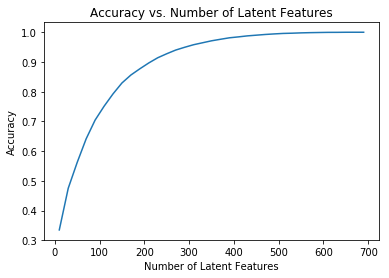

In [42]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [6]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [44]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(test_idx, user_item_train.index, assume_unique=True))

20

In [45]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(user_item_test.index) - len(np.intersect1d(test_idx, user_item_train.index, assume_unique=True))

662

In [46]:
# How many articles can we make predictions for in the test set?
len(np.intersect1d(test_arts, user_item_train.columns, assume_unique=True))

574

In [47]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(user_item_test.columns) - len(np.intersect1d(test_arts, user_item_train.columns, assume_unique=True))

0

In [2]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [7]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape 

((4487, 4487), (714,), (714, 714))

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

generate users and articles we can make predictions from the test set: 
(20, 574)
pull the users rows we can make predictions from u_train: 
(20, 4487)
pull the article columns we can make predictions from vt_train: 
(714, 574)
the value of errors from the loop:
[221.0, 225.0, 227.0, 229.0, 232.0, 239.0, 240.0, 238.0, 249.0, 248.0, 249.0, 249.0, 253.0, 256.0, 252.0, 257.0, 259.0, 259.0, 257.0, 260.0, 261.0, 261.0, 269.0, 269.0, 269.0, 269.0, 272.0, 270.0, 270.0, 269.0, 267.0, 270.0, 272.0, 273.0, 276.0, 277.0, 277.0, 274.0, 275.0, 276.0, 277.0, 279.0, 278.0, 278.0, 278.0, 280.0, 278.0, 277.0, 282.0, 283.0, 285.0, 285.0, 289.0, 288.0, 288.0, 291.0, 292.0, 291.0, 293.0, 294.0, 296.0, 298.0, 298.0, 297.0, 298.0, 302.0, 303.0, 301.0, 300.0, 303.0, 302.0, 302.0, 303.0, 304.0, 305.0, 306.0, 307.0, 310.0, 312.0, 313.0, 315.0, 315.0, 317.0, 318.0, 318.0, 318.0, 319.0, 321.0, 320.0, 318.0, 320.0, 321.0, 321.0, 326.0, 327.0, 325.0, 326.0, 327.0, 327.0, 328.0, 329.0, 332.0, 332.0, 334.0, 335.0, 3

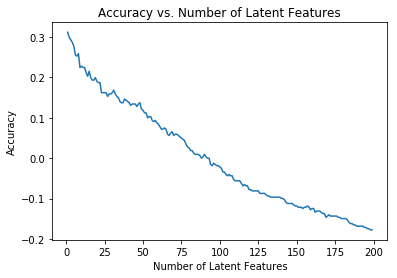

In [8]:
# 可预测的test里的用户ids
pred_user_ids = np.intersect1d(test_idx, user_item_train.index, assume_unique=True)
# 可预测的test里的文章ids
pred_arts_ids = np.intersect1d(test_arts, user_item_train.columns, assume_unique=True)
# 可预测的test矩阵（用来验证预测结果的）
user_item_test_pred = user_item_test.loc[pred_user_ids, pred_arts_ids]
print("generate users and articles we can make predictions from the test set: ") 
print(user_item_test_pred.shape)


# u_train里提取那20个test里有的用户id对应的行(用于后续的点积运算-预测)
u_train_pred = u_train[user_item_train.index.isin(pred_user_ids)]
print("pull the users rows we can make predictions from u_train: ") 
print(u_train_pred.shape)

# vt_train里提取那574个test里有的文章id对应的列(用于后续的点积运算-预测)
vt_train_pred = vt_train[:,user_item_train.columns.isin(pred_arts_ids)]
print("pull the article columns we can make predictions from vt_train: ") 
print(vt_train_pred.shape)

# s_train是潜在因子矩阵，不用动。

# 看不同的潜在因子个数，预测的结果如何：
num_latent_feats = np.arange(1,200,1) # train集的SVD还是生成了714个潜在因子，所以循环还是到710
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train_pred[:, :k], vt_train_pred[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_pred, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
print("the value of errors from the loop:") 
print(sum_errs)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test[df_test['user_id'].isin(pred_user_ids)].shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

The best latent features number is 1...

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

From the result we can see, the accuracy decreases along with the increase of number of latent features. It's not what I expected... maybe it means NOT the more latent features the better?

The highest accuracy% is still low, seems the model is not a good recommendation model. However, we only have 20 users which can predict from test data set. I think we need more data to test the model result, then determine whether it's better.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [9]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0